In [97]:
import os
import pathlib
import shutil
import zipfile

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn import metrics
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

In [120]:
# set to directory containing image folders
DATADIR = "/content/data"

# setting batching and image resizing parameters
batch_size = 128
img_height = 128
img_width = 512

# creating training, testing and validation datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATADIR,
  validation_split=0.2,
  subset="training",
  seed=39,
  image_size=(img_height, img_width), # resizing images
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  DATADIR,
  validation_split=0.2,
  subset="validation",
  seed=39,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  DATADIR,
  validation_split=0.2,
  subset="validation",
  seed=39,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# creating batches for testing and validation
val_batches = tf.data.experimental.cardinality(val_ds)
test_batches = tf.data.experimental.cardinality(test_ds)

val_ds = val_ds.take(val_batches // 2)
test_ds = test_ds.skip(val_batches // 2)

# convert batch of images from RGB to grayscale
def rgb_to_grayscale(images, labels):
    grayscale_images = tf.image.rgb_to_grayscale(images)
    return grayscale_images, labels

train_ds_gray = train_ds.map(rgb_to_grayscale)
val_ds_gray = val_ds.map(rgb_to_grayscale)
test_ds_gray = test_ds.map(rgb_to_grayscale)

Found 4384 files belonging to 4 classes.
Using 3508 files for training.
Found 4384 files belonging to 4 classes.
Using 876 files for validation.
Found 4384 files belonging to 4 classes.
Using 876 files for validation.


# Build a CNN Model

```
tf.keras.layers.Conv2D(
    filters,
    kernel_size,
    strides=(1, 1),
    padding='valid',
    data_format=None,
    dilation_rate=(1, 1),
    groups=1,
    activation=None,
    use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    **kwargs
)
```

In [160]:
model = models.Sequential()

# Input and rescaling
model.add(layers.Input(shape=(img_height, img_width, 1)))
model.add(layers.Rescaling(1./255))

# Conv block 1
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Conv block 2
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Conv block 3
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Conv block 4
model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Global average pooling
model.add(layers.GlobalAveragePooling2D())

# Dense layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.1))

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.1))

# Output layer for 4 classes
model.add(layers.Dense(4, activation='softmax'))

model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_14 (Rescaling)        │ (None, 128, 512, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 128, 512, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 128, 512, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 64, 256, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 64, 256, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 64, 256, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 32, 128, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 32, 128, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 32, 128, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 16, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 16, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 16, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 8, 32, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 431,172 (1.64 MB)

 Trainable params: 430,212 (1.64 MB)

 Non-trainable params: 960 (3.75 KB)

In [161]:
# implementing caching to improve performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds_gray = train_ds_gray.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_gray = val_ds_gray.cache().prefetch(buffer_size=AUTOTUNE)

# number of training epochs
epochs = 100

# setting loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# setting optimizer and loss function
model.compile(optimizer='adam',
              loss=loss,
              metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, start_from_epoch=50),
    ReduceLROnPlateau(factor=0.5, patience=3)
]

# fitting the model
history = model.fit(
    train_ds_gray,
    validation_data=val_ds_gray,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 218ms/step - accuracy: 0.3875 - loss: 1.2943 - val_accuracy: 0.2578 - val_loss: 1.4483 - learning_rate: 0.0010
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.4930 - loss: 1.1292 - val_accuracy: 0.2578 - val_loss: 1.6675 - learning_rate: 0.0010
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5220 - loss: 1.0692 - val_accuracy: 0.2578 - val_loss: 1.6964 - learning_rate: 0.0010
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5435 - loss: 1.0175 - val_accuracy: 0.2578 - val_loss: 1.7848 - learning_rate: 0.0010
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.6006 - loss: 0.9371 - val_accuracy: 0.2578 - val_loss: 2.2309 - learning_rate: 5.0000e-04
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.6171 - loss: 0.9072 - val_accuracy: 0.2578 - val_loss: 2.6142 - learning_rate: 5.0000e-04
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.6226 - loss:

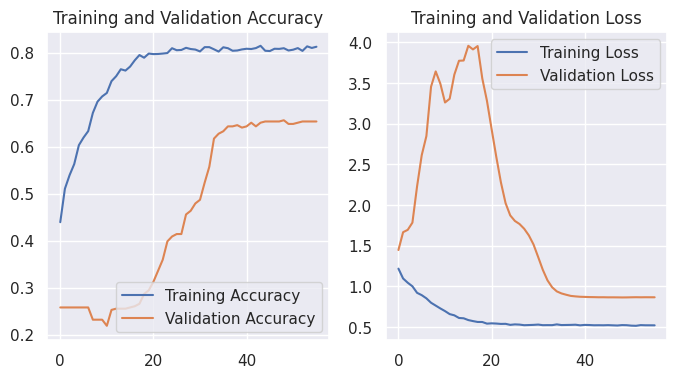

In [168]:
# plotting training statistics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [169]:
loss, accuracy = model.evaluate(val_ds_gray)

print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6641 - loss: 0.8432
Validation Loss: 0.8670
Validation Accuracy: 0.6484


# Evaluate the Model

In [170]:
# evaluating the model using test data
y_true = []
y_pred = []

for images, labels in test_ds_gray:
    y_true.extend(labels.numpy())
    y_pred.extend(model.predict(images))

predicted_labels = np.argmax(np.array(y_pred), axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [171]:
# printing evaluation metrics
def print_eval(y_true, y_pred):
    mle = np.argmax(y_pred, axis=1)
    accuracy = metrics.accuracy_score(y_true,
                                      mle)

    precision = metrics.precision_score(y_true,
                                        mle,
                                        average='weighted')

    recall = metrics.recall_score(y_true, mle, average='weighted')
    f1 = metrics.f1_score(y_true, mle,  average='weighted')
    roc_auc = metrics.roc_auc_score(
        y_true,   y_pred,  average='weighted',  multi_class='ovr')

    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  ROC AUC Score: {roc_auc:.4f}")


print_eval(y_true, y_pred)

  Accuracy: 0.6098
  Precision: 0.6181
  Recall: 0.6098
  F1 Score: 0.6121
  ROC AUC Score: 0.8485


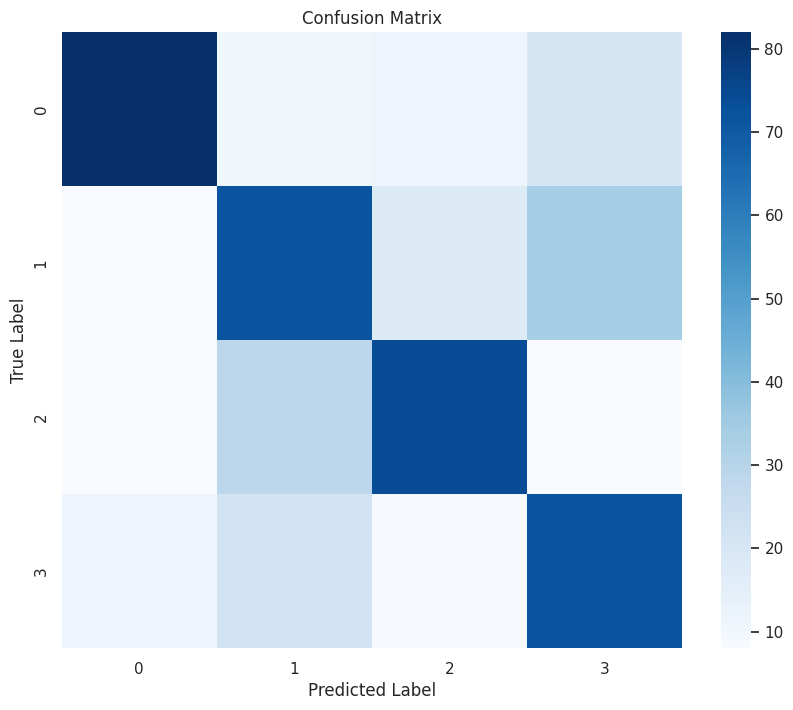

In [172]:
# plotting a multiclass confusion matrix
conf_matrix = metrics.confusion_matrix(y_true, predicted_labels)


plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=False, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [173]:
print("--- Model Analysis ---")

# analysis of training and validation history
print("\nTraining History Analysis:")
print(f"  Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"  Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"  Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"  Final Validation Loss: {history.history['val_loss'][-1]:.4f}")

# analysis of confusion matrix
print("\nConfusion Matrix Analysis:")
total_samples = np.sum(conf_matrix)
correct_predictions = np.trace(conf_matrix)
print(f"  Total samples in evaluation: {total_samples}")
print(f"  Correct predictions: {correct_predictions}")
print(f"  Overall Accuracy from Confusion Matrix: {correct_predictions / total_samples:.4f}")

# classification metrics
print("\nClassification Metrics Analysis:")
print_eval(y_true, y_pred)

--- Model Analysis ---

Training History Analysis:
  Final Training Accuracy: 0.8127
  Final Validation Accuracy: 0.6536
  Final Training Loss: 0.5223
  Final Validation Loss: 0.8672

Confusion Matrix Analysis:
  Total samples in evaluation: 492
  Correct predictions: 300
  Overall Accuracy from Confusion Matrix: 0.6098

Classification Metrics Analysis:
  Accuracy: 0.6098
  Precision: 0.6181
  Recall: 0.6098
  F1 Score: 0.6121
  ROC AUC Score: 0.8485
